scheme:

* 1) for data transfer, pick 1st sleep api (h2d) fo stream-0, current cc = 1 (concurrency),
* 2) check whether there is overalp with stream-
* 2) if there is overlap, finish cc=1, start from cc++ (cc=2), predit the future ending time
* 3) during the predicted ending time, check whether there is overlap with stream-2
* 4) if there is overalap, finish cc=2, start from cc++ (cc=3), predict the future ending time
* 5) go to step 3) , search through all the cuda streams
* 6) for each time range, we need to find out how many apis have overlap and which-pair have conflicts or not

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import pandas as pd
import numpy as np
import os
import sys # error msg, add the modules
import operator # sorting
from math import *
import matplotlib.pyplot as plt

sys.path.append('../../')

import cuda_timeline
import read_trace
import avgblk
import cke
from model_param import *

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# gpu info

In [2]:
gtx950 = DeviceInfo()
gtx950.sm_num = 6
gtx950.sharedmem_per_sm = 49152
gtx950.reg_per_sm = 65536
gtx950.maxthreads_per_sm = 2048

In [3]:
# init SM resources
SM_resList, SM_traceList = init_gpu(gtx950)

In [4]:
#SM_resList[0]

In [5]:
SM_traceList[0]

,sm_id,block_id,block_start,block_end,batch_id,kernel_id,active


# Understand the input

In [6]:
trace_s1 = 'trace_s1_5m.csv'
df_trace_s1 = read_trace.Trace2dataframe(trace_s1)

trace_s3 = 'trace_s3_5m.csv'
df_trace_s3 = read_trace.Trace2dataframe(trace_s3)

In [7]:
#df_trace_s1

/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1220: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


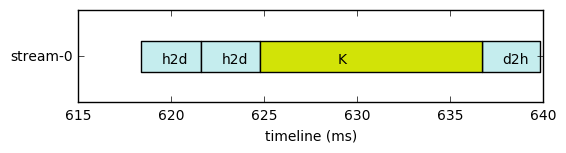

In [8]:
cuda_timeline.plot_trace(df_trace_s1)

In [9]:
#cuda_timeline.plot_trace(df_trace_s2)

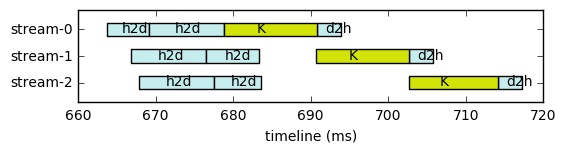

In [10]:
cuda_timeline.plot_trace(df_trace_s3)

# Kernel Info from the single stream

In [11]:
# extract kernel info from trace
# warning: currently lmted to one kernel

kernel = read_trace.GetKernelInfo(df_trace_s1, gtx950)

Dump_kernel_info(kernel)

Kernel Info
		blockDim 256.0
		gridkDim 19532.0
		regs 28.0
		shared memory 0.0
		runtime (ms) 11.914429
		average block execution time (ms) 0.0292737813268
		start time (ms) 0


# model 3 cuda streams

In [12]:
# for each stream, have a dd for each kernel
stream_kernel_list = []

stream_num = 3

for sid in range(stream_num):
    #print sid
    # key will be the kernel order
    # value will be the kernel info
    kern_dd = {}
    kern_dd[0] = Copy_kernel_info(kernel)
    stream_kernel_list.append(kern_dd)
    
    
Dump_kernel_info(stream_kernel_list[0][0])

Kernel Info
		blockDim 256.0
		gridkDim 19532.0
		regs 28.0
		shared memory 0.0
		runtime (ms) 11.914429
		average block execution time (ms) 0.0292737813268
		start time (ms) 0


### start kernel from beginning

In [13]:
df_s1_trace_timing = read_trace.Get_timing_from_trace(df_trace_s1)
df_s1 = read_trace.Reset_starting(df_s1_trace_timing)

In [14]:
df_s1

,stream,api_type,start,end,size,duration
0,0.0,h2d,0.000000,3.187298,19073.486,3.187298
1,0.0,h2d,3.188514,6.384227,19073.486,3.195713
2,0.0,kern,6.391203,18.305632,0.000,11.914429
3,0.0,d2h,18.311008,21.445857,19073.486,3.134849


### set the h2d start for all the cuda streams

In [15]:
# find when to start the stream and update the starting pos for the trace
H2D_H2D_OVLP_TH = 3.158431

df_cke_list = cke.init_trace_list(df_s1, stream_num = stream_num, h2d_ovlp_th = H2D_H2D_OVLP_TH)

stream_startTime : 3.160431
stream_startTime : 6.320862


In [16]:
df_cke_list[0]

,stream,api_type,start,end,size,duration
0,0,h2d,0.000000,3.187298,19073.486,3.187298
1,0,h2d,3.188514,6.384227,19073.486,3.195713
2,0,kern,6.391203,18.305632,0.000,11.914429
3,0,d2h,18.311008,21.445857,19073.486,3.134849


In [17]:
df_cke_list[1]

,stream,api_type,start,end,size,duration
0,1,h2d,3.160431,6.347729,19073.486,3.187298
1,1,h2d,6.348945,9.544658,19073.486,3.195713
2,1,kern,9.551634,21.466063,0.000,11.914429
3,1,d2h,21.471439,24.606288,19073.486,3.134849


In [18]:
df_cke_list[2]

,stream,api_type,start,end,size,duration
0,2,h2d,6.320862,9.508160,19073.486,3.187298
1,2,h2d,9.509376,12.705089,19073.486,3.195713
2,2,kern,12.712065,24.626494,0.000,11.914429
3,2,d2h,24.631870,27.766719,19073.486,3.134849


### merge all the cuda stream trace together

In [19]:
df_all_api = cke.init_sort_api_with_extra_cols(df_cke_list)

In [20]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,pred_end
0,0.000000,3.187298,h2d,19073.486,0.0,sleep,5984.217980,0.0,19073.486,0.0,0.0
4,3.160431,6.347729,h2d,19073.486,1.0,sleep,5984.217980,0.0,19073.486,0.0,0.0
1,3.188514,6.384227,h2d,19073.486,0.0,sleep,5968.460247,0.0,19073.486,0.0,0.0
8,6.320862,9.508160,h2d,19073.486,2.0,sleep,5984.217980,0.0,19073.486,0.0,0.0
5,6.348945,9.544658,h2d,19073.486,1.0,sleep,5968.460247,0.0,19073.486,0.0,0.0
2,6.391203,18.305632,kern,0.000,0.0,sleep,0.000000,0.0,0.000,0.0,0.0
9,9.509376,12.705089,h2d,19073.486,2.0,sleep,5968.460247,0.0,19073.486,0.0,0.0
6,9.551634,21.466063,kern,0.000,1.0,sleep,0.000000,0.0,0.000,0.0,0.0
10,12.712065,24.626494,kern,0.000,2.0,sleep,0.000000,0.0,0.000,0.0,0.0
3,18.311008,21.445857,d2h,19073.486,0.0,sleep,6084.339628,0.0,19073.486,0.0,0.0


### start algorithm

In [21]:
simPos = 0.0
more_streams = stream_num - 1

active_stream_dd = {}
for s in range(stream_num):
    active_stream_dd[s] = 0
#print active_stream_dd

round = 1
while not cke.AllDone(df_all_api):
    df_all_api, r1, r1_stream = cke.pick_base_call(df_all_api)
    df_all_api = SetWake(df_all_api, r1)
    print('new round => row {}, stream-id {}'.format(r1, r1_stream))
    active_stream_dd[r1_stream] += 1
    #print active_stream_dd
    
    # simulation position
    #simPos = GetInfo(df_all_api, r1, 'start')
    
    #if round == 2: break
    
    for i in range(0, more_streams):
        df_all_api, r2, r2_stream = cke.start_next_call(df_all_api)
        print('=> pick row {}, stream-id {}'.format(r2, r2_stream))
        
        print('simulation position : {}'.format(simPos))
        
        # current position
        curPos = GetInfo(df_all_api, r2, 'start')
        print('current position : {}'.format(curPos))
        
        if round == 2 and i == 0: break
            
        # check the active stream
        if active_stream_dd[r2_stream] == 0:
            active_stream_dd[r2_stream] +=  1
                    
            # update trace during the range
            df_all_api = cke.update_by_range(df_all_api, simPos, curPos)
                             
        else:
            #
            # there is stream api ahead, find out which call and terminate it
            row_2nd = Find_prevapi_samestream(df_all_api, r2, r2_stream)
            print('end prev api call at row {}'.format(row_2nd))
            #
            # end the target row, update the bytes for other call
            df_all_api = cke.end_target_row(df_all_api, row_2nd, simPos, curPos)
            #
            # update curPos, since r2 start has been shifted right
            curPos = GetInfo(df_all_api, r2, 'start')
            df_all_api = UpdateCell(df_all_api, r2, 'current_pos', curPos)
            print('row {}, Updated current position : {}'.format(r2, curPos))
            #
            # assume there is no ovlp between row_2nd end and r2_start
            row2nd_end = GetInfo(df_all_api, row_2nd, 'end')
            df_all_api = cke.move_wake_for_coming_call(df_all_api, row2nd_end, curPos)
            #
            # update the count for active stream pool: remove row2nd, add r2 to the pool
            active_stream_dd[r2_stream] =  1
        
        
        # shift right
        simPos = curPos
        
        #if i == 0: break
            
    
    round += 1

new round => row 0, stream-id 0.0
=> pick row 4, stream-id 1.0
simulation position : 0.0
current position : 3.160431
wake list [0] 
[0]
[]
[]
=> pick row 1, stream-id 0.0
simulation position : 3.160431
current position : 3.188514
end prev api call at row 0
wake list [0, 4] 
2
row 1, Updated current position : 3.215381
move_wake_for_coming_call, wake list [4] 
new round => row 4, stream-id 1.0


In [22]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,pred_end
0,0.000000,3.214165,h2d,19073.486,0.0,done,5984.217980,19073.486000,0.000000,3.214165,3.214165
4,3.160431,6.347729,h2d,19073.486,1.0,wake,5984.217980,19241.540794,18905.431206,3.160431,6.347729
1,3.215381,6.411094,h2d,19073.486,0.0,wake,5968.460247,0.000000,19073.486000,3.215381,6.411094
8,6.320862,9.508160,h2d,19073.486,2.0,sleep,5984.217980,0.000000,19073.486000,0.000000,0.000000
5,6.348945,9.544658,h2d,19073.486,1.0,sleep,5968.460247,0.000000,19073.486000,0.000000,0.000000
2,6.418070,18.332499,kern,0.000,0.0,sleep,0.000000,0.000000,0.000000,0.000000,18.332499
9,9.509376,12.705089,h2d,19073.486,2.0,sleep,5968.460247,0.000000,19073.486000,0.000000,0.000000
6,9.551634,21.466063,kern,0.000,1.0,sleep,0.000000,0.000000,0.000000,0.000000,0.000000
10,12.712065,24.626494,kern,0.000,2.0,sleep,0.000000,0.000000,0.000000,0.000000,0.000000
3,18.337875,21.472724,d2h,19073.486,0.0,sleep,6084.339628,0.000000,19073.486000,0.000000,21.472724


In [23]:
#
# run above
# 